# Stage 10b — Time-Series Modeling (Regression)

In [3]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Paths
DATA_DIR = Path("../data")
PROC = DATA_DIR / "processed"
FEAT_PATH = PROC / "IYR_features_project.csv"
OUT_PRED = PROC / "IYR_predictions_stage10b.csv"

MODEL_DIR = Path("../model")
MODEL_DIR.mkdir(exist_ok=True)

In [4]:
df = pd.read_csv(FEAT_PATH, parse_dates=["Date"]).sort_values("Date").reset_index(drop=True)

# Target = next day's Close
df["target_close_t1"] = df["Close"].shift(-1)

# Drop rows with NaN target
df = df.dropna(subset=["target_close_t1"]).copy()

features = [c for c in df.columns if c not in ["Date", "target_close_t1"]]
X = df[features]
y = df["target_close_t1"]

df[["Date", "Close", "target_close_t1"]].head()

,Date,Close,target_close_t1
0,2022-01-04,104.979668,101.867874
1,2022-01-05,101.867874,101.849625
2,2022-01-06,101.849625,101.165215
3,2022-01-07,101.165215,100.654190
4,2022-01-10,100.654190,100.909698


In [5]:
split_idx = int(len(df) * 0.8)

X_train, y_train = X.iloc[:split_idx], y.iloc[:split_idx]
X_valid, y_valid = X.iloc[split_idx:], y.iloc[split_idx:]
dates_valid = df["Date"].iloc[split_idx:]

len(X_train), len(X_valid)

(396, 99)

In [6]:
tscv = TimeSeriesSplit(n_splits=5)

pipe = Pipeline([
    ("scale", StandardScaler(with_mean=False)),  # harmless even for trees
    ("rf", RandomForestRegressor(random_state=42, n_jobs=-1))
])

param_grid = {
    "rf__n_estimators": [200, 400],
    "rf__max_depth": [None, 10, 20],
    "rf__min_samples_leaf": [1, 3, 5],
}

gcv = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=tscv,
    n_jobs=-1,
    verbose=0
)

gcv.fit(X_train, y_train)

print("Best params:", gcv.best_params_)
print("Best CV MAE:", -gcv.best_score_)

Best params: {'rf__max_depth': 20, 'rf__min_samples_leaf': 3, 'rf__n_estimators': 400}
Best CV MAE: 2.946043920405176


MAE:  1.0585
RMSE: 1.4217
R²:   0.9101


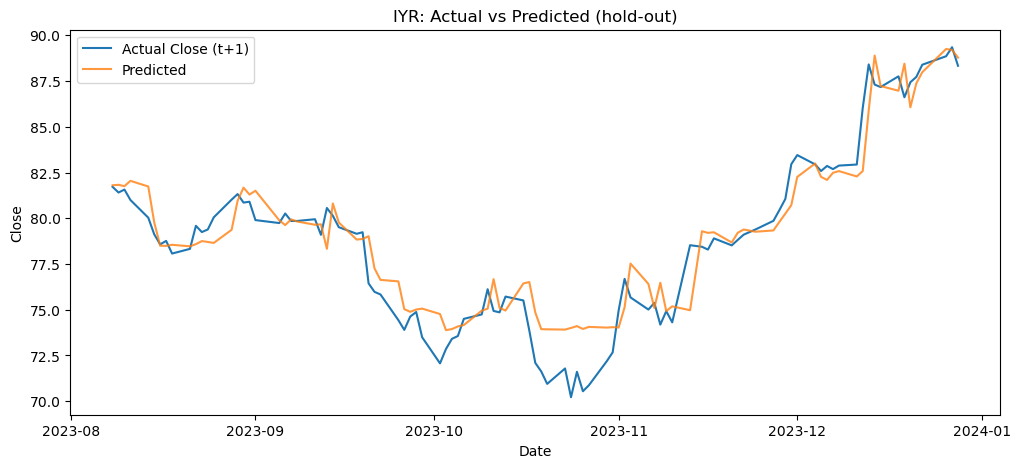

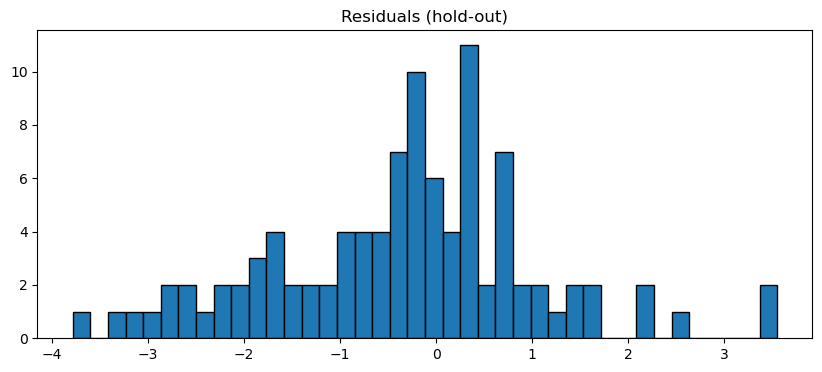

count    99.000000
mean     -0.349077
std       1.385199
min      -3.786092
25%      -1.089099
50%      -0.206708
75%       0.368946
max       3.554239
dtype: float64

In [8]:
# --- Evaluate on hold-out block (fixed for older sklearn) ---
pred_valid = best_model.predict(X_valid)

mae = mean_absolute_error(y_valid, pred_valid)
mse = mean_squared_error(y_valid, pred_valid)  # no 'squared' kwarg
rmse = np.sqrt(mse)                            # compute RMSE manually
r2 = r2_score(y_valid, pred_valid)

print(f"MAE:  {mae:0.4f}")
print(f"RMSE: {rmse:0.4f}")
print(f"R²:   {r2:0.4f}")

# Plot predictions vs actual
plt.figure(figsize=(12,5))
plt.plot(dates_valid, y_valid.values, label="Actual Close (t+1)")
plt.plot(dates_valid, pred_valid, label="Predicted", alpha=0.8)
plt.title("IYR: Actual vs Predicted (hold-out)")
plt.xlabel("Date"); plt.ylabel("Close"); plt.legend(); plt.show()

# Residuals
resid = y_valid.values - pred_valid
plt.figure(figsize=(10,4))
plt.hist(resid, bins=40, edgecolor="k")
plt.title("Residuals (hold-out)")
plt.show()

pd.Series(resid).describe()

In [9]:
out = pd.DataFrame({
    "Date": dates_valid.values,
    "y_actual": y_valid.values,
    "y_pred": pred_valid
})

out.to_csv(OUT_PRED, index=False)
print("Saved predictions to:", OUT_PRED)

import joblib
model_path = MODEL_DIR / "rf_time_pipeline_stage10b.joblib"
joblib.dump(best_model, model_path)
print("Saved model to:", model_path)

Saved predictions to: ../data/processed/IYR_predictions_stage10b.csv
Saved model to: ../model/rf_time_pipeline_stage10b.joblib


## Assumptions & Risks (Stage 10b)

- Used time-aware split (no shuffling) to avoid look-ahead bias.  
- Target = next-day Close, predicted using lag/rolling features.  
- Random Forest captures non-linearities but is less interpretable.  
- Market regime shifts (interest rates, shocks) may break patterns → need retraining.  
- Residuals are not perfectly normal (fat tails are common in finance).  
- Metrics (MAE, RMSE, R²) show point accuracy; real deployment may need intervals.  